In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F

from env import *
from policy.NN_model import DRL
from policy.qr_one import Qroute

In [3]:
network = 'topology/6x6.net'
net_name = '6x6'

memory_capa = 50000
epsilon = 0
static = False

# Obtain Off-line Memory

In [4]:
nw = Network(network, is_drop=False)
nw.agent = Qroute(nw, net_name=net_name, memory_capa=memory_capa)
nw.agent.load(f'{net_name}/qr/1.0')
nw.agent.epsilon = 0

# times must let the memory be full
# 5,000 --> memory 50,000 for lata/
res = nw.train_one_load(50000, 1.0, lr={'q': 0.4})
nw.clean()

100%|██████████| 50000/50000 [01:00<00:00, 828.82it/s] 


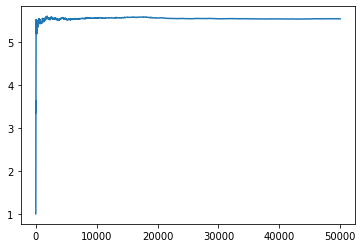

In [5]:
plt.plot(res['route_time'])

In [6]:
m = nw.agent.memory

In [7]:
m

array([[ 0.,  0.,  0., ...,  0., 22.,  1.],
       [ 0.,  0.,  0., ...,  0., 15.,  1.],
       [ 0.,  0.,  0., ...,  0., 16.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0., 21.,  1.],
       [ 0.,  0.,  0., ...,  0., 30.,  1.],
       [ 0.,  0.,  0., ...,  0., 19.,  1.]])

In [8]:
# mem = pd.DataFrame(m)
# mem.to_csv('df/%s_off_line_memory.csv'%(net_name))
# mem.tail()

# Read stored memory

In [9]:
# m = pd.read_csv('df/%s_off_line_memory.csv'%(net_name), dtype='float32').iloc[:,1:]
# m = np.array(m).round(0)

In [10]:
m  # s, a, r, s', a', f

array([[ 0.,  0.,  0., ...,  0., 22.,  1.],
       [ 0.,  0.,  0., ...,  0., 15.,  1.],
       [ 0.,  0.,  0., ...,  0., 16.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0., 21.,  1.],
       [ 0.,  0.,  0., ...,  0., 30.,  1.],
       [ 0.,  0.,  0., ...,  0., 19.,  1.]])

# Build a new NN agent

In [11]:
nw = Network(network, is_drop=False)
nw.agent = DRL(nw, net_name, epsilon=epsilon, static=static)
nodes = nw.agent.config.number_of_node
# nw.agent.config.node_input = 1
inp = nw.agent.config.node_input
out = nw.agent.config.node_output
nodes, inp, out

(36, 3, 8)

In [12]:
from policy.network import GraphAttentionLayer
from policy.network import sxsGAT, sxsDQN

In [13]:
model = 'GAT'
eval_net = sxsDQN(nodes, inp, out) if model == 'DQN' else sxsGAT(nodes, inp, out)
target_net = sxsDQN(nodes, inp, out) if model == 'DQN' else sxsGAT(nodes, inp, out)
# net = [sxsGAT(nodes, inp, out, len(nw.agent.links[i])) for i in range(nodes)]

In [14]:
nw.agent.build_model(eval_net, target_net)
lr = 5e-3
nw.agent.reset_optimizer(lr)

In [15]:
# print(nw.agent.config)
print(nw.agent)

Network Topology Information
Number of Node: 36
Input dimension 3
-----------------------------------
Hyper Parameter
Learning rate: 4e-05
Reward_decay: 0.99
Memory capacity: 2000
Batch size: 256
Tau: 0.05
-----------------------------------
Memory shape (2000, 220)
-----------------------------------
Network shape sxsGAT(
  (GAT1): GraphAttentionLayer (3 -> 4)
  (GAT2): GraphAttentionLayer (4 -> 8)
  (fc1): Linear(in_features=288, out_features=54, bias=True)
  (out): Linear(in_features=54, out_features=36, bias=True)
)
-----------------------------------
Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)
-----------------------------------


In [16]:
times = 1000
nw.agent.load(f'{net_name}/{model}/supervised_{times}')

# start training

In [31]:
pre_time = 5000
nw.agent.pre_training(m, pre_time)

100%|██████████| 5000/5000 [07:08<00:00, 11.66it/s]


In [32]:
# nw.agent.store(f'{net_name}/{model}/supervised_{pre_time}')

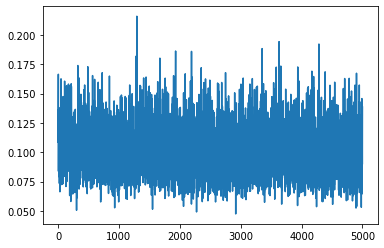

In [33]:
plt.plot(nw.agent.loss)

# Test convergence

In [34]:
res = nw.train_one_load(2000, 0.1)

100%|██████████| 2000/2000 [01:19<00:00, 25.30it/s]


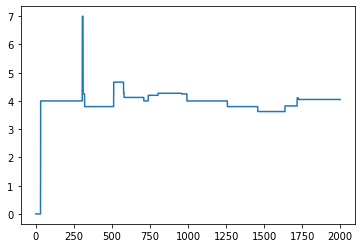

In [35]:
plt.plot(res['route_time'])

In [36]:
print(nw.end_packets/nw.all_packets)
nw.clean()

0.09743589743589744


In [ ]:
# nw.agent.store(f'{net_name}/{model}/1.0')

## DQN with 4000 to converge
## GAT with 2000 to converge